In [2]:
import cPickle
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## "Reading" sequences

## Going through character sequence

### Plotting Stuff...

This for now is just a demo of how easy it is to get at the various components of an NN and plot them

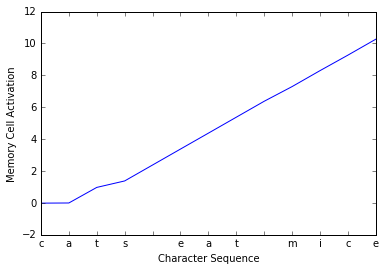

In [36]:
# ranges from 0 to len(input_char_seq) - 1
# keep cell index 11 in mind
plt.plot(cats[0][11])
plt.ylabel("Memory Cell Activation")
plt.xlabel("Character Sequence")
# sets char IDs as tick labels on the X axis
plt.xticks(input_positions, list("cats eat mice"))
plt.show()

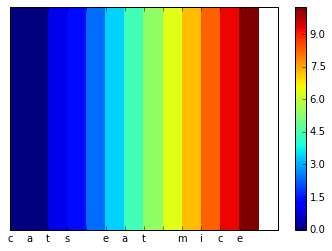

In [37]:
plt.pcolormesh(np.expand_dims(cats[0][11], axis=0))
# sets char IDs as tick labels on the X axis
plt.xticks(input_positions, list("cats eat mice"))
plt.yticks([])
plt.ylim(0, 0.1)
plt.colorbar()
plt.show()

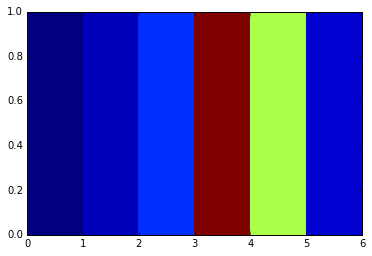

In [3]:
plt.pcolormesh(np.random.rand(1, 6))
plt.show()

## Hinton Diagrams

In [30]:
from stoogeplot import hinton_diagram

In [11]:
randomness = np.random.rand(100,25) - 0.5

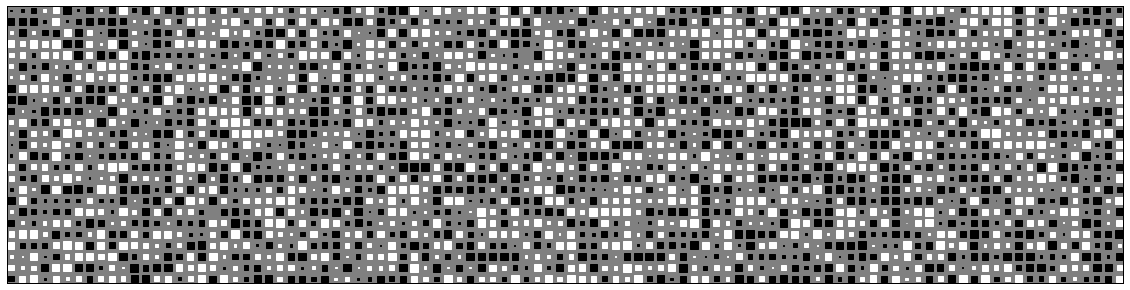

In [31]:
f = plt.figure(figsize=(20, 20))
# axes = plt.axes()
hinton_diagram(randomness)